# **Computer Vision -  Deep Learning on X_rays**

**Created by Ahmed Bennasser**

**--------------------------**

**----------------------------**

In [1]:
!pip install torchinfo

In [2]:
!nvidia-smi


Sat Oct  4 15:31:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# 1.**import**

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from collections import Counter

import torch
from torch import nn , optim
from torch.utils.data  import Dataset , DataLoader
from torchvision import transforms , datasets
from torchinfo import summary
from torchvision.models import efficientnet_v2_s , resnet18                #architecture efficientnet


from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
from pathlib import Path

import os
import shutil
import random

from  tqdm  import tqdm

from typing import Dict,List
import warnings
warnings.filterwarnings('ignore')
print(os.getcwd())

/content


#**2. Load Data and Exploratory Data Analysis**







Notre Data est organizer en 4 repertoire ("covid  , normal , lung_opacity , viral pneumonia")

la classe **COVID** : Pneumonie viral cusée par SARS-COV-2                  => Detecter COVID specifiquement

la classe **Viral-Pneumonie**: autres pneumonies virales autre que COVID19 => differncier entre les maladies de meme genre

la classe **NORMAL** : poumons sains                                        => apprendre ce qu'est un poumon sans infection

la classe **LUNG_OPACITY** : radiographies avec opacites                    => aider a reperer les signes de maladie


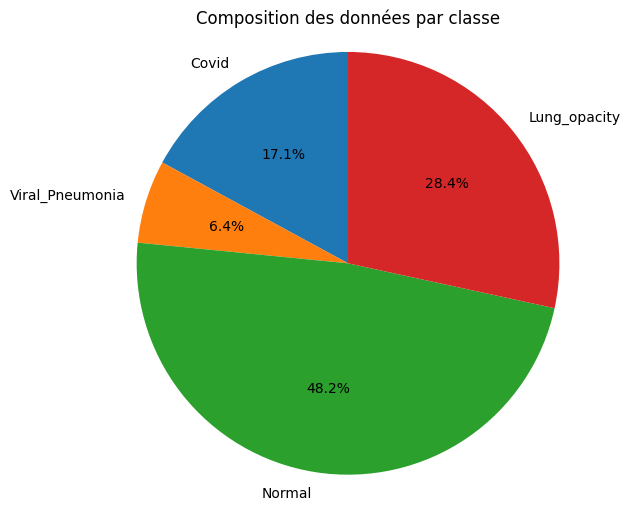

In [ ]:
# voyons comment notre Data est distribuée
labels = ['Covid', 'Viral_Pneumonia', 'Normal', 'Lung_opacity']
values = [3616, 1345, 10192 , 6012]           # Valeurs associées aux classes


plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)

# titre
plt.title("Composition des données par classe")

# Affichage
plt.axis('equal')
plt.show()


on remarque que la classe Normal prend presque 50% de la distribution , et une classe comme Viral_Pneumonia ne contibue que par 6% ( 6% << 25%) ,  ce qui va causer potentiellemnet un Overfitting , car le model aura tendance a predire Normal plus ce que attendu , juste parce qu'il la vu beaucoup de fois


donc on va essayer d'organizer notre Data
1) on va diminuer le nombre des images Noraml à 5000 images
2) on diminue le nombre des images Lung_opacity à 5000 images
3) on augmente le nombre d'images de Covid et Viral_Pneumonia a 5000 images (on genere d'autres images automatiquement )


le choix de 5000 images par classe est un bon compromis surtout pour ne pas avoir trop d Overfitting et , aussi pour accelerer le model (GPU)

On a stocké les images dans
google Drive

In [4]:
# notre Data est enregistrer dans Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# on definit une fonction augumentation qui permet de generer autres images similaire au covid et viral , en changeant le zoom et la limunosite

In [ ]:
random.seed(42)
def augmentation(target_count, existing_count, source_dir, files, output_dir):
    transform = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])

    os.makedirs(output_dir, exist_ok=True)

    # Copier toutes les images originales
    for f in files:
        src = os.path.join(source_dir, f)
        dst = os.path.join(output_dir, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    to_generate = target_count - existing_count
    if to_generate <= 0:
        print(f"Aucune augmentation nécessaire dans {output_dir}")
        return os.listdir(output_dir)

    i = 0
    while i < to_generate:
        img_name = files[i % len(files)]
        img_path = os.path.join(source_dir, img_name)
        try:
            img = Image.open(img_path).convert('L')
            img_t = transform(img)
            img_aug = transforms.ToPILImage()(img_t)
            save_path = os.path.join(output_dir, f"aug_{i}_{img_name}")
            img_aug.save(save_path)
            i += 1
        except Exception as e:
            print(f"Erreur sur {img_name}: {e}")
            i += 1

    return os.listdir(output_dir)



# on cree un nouveau dossier avec les 4 classes , ou chacune contient  5000 images !!!

In [ ]:

# Répertoires
input_dir = "/content/drive/MyDrive/COVID-19_Dataset"
output_dir = "/content/drive/MyDrive/COVID-19_Radiography_Dataset_split"

random.seed(42)
target_count = 5000

# Normal
normal_dir = os.path.join(input_dir, "Normal")
normal_files = os.listdir(normal_dir)
normal_sample = random.sample(normal_files, target_count)
output_normal = os.path.join(output_dir, "Normal")
os.makedirs(output_normal, exist_ok=True)
for f in normal_sample:
    shutil.copy(os.path.join(normal_dir, f), os.path.join(output_normal, f))

# Lung_Opacity
lung_dir = os.path.join(input_dir, "Lung_Opacity")
lung_files = os.listdir(lung_dir)
lung_sample = random.sample(lung_files, target_count)
output_lung = os.path.join(output_dir, "Lung_Opacity")
os.makedirs(output_lung, exist_ok=True)
for f in lung_sample:
    shutil.copy(os.path.join(lung_dir, f), os.path.join(output_lung, f))

# Covid (augmentation)
covid_dir = os.path.join(input_dir, "Covid")
covid_files = os.listdir(covid_dir)
output_covid = os.path.join(output_dir, "Covid")
covid_aug_files = augmentation(target_count, len(covid_files), covid_dir, covid_files, output_covid)

# Viral Pneumonia (augmentation)
viral_dir = os.path.join(input_dir, "Viral_Pneumonia")
viral_files = os.listdir(viral_dir)
output_viral = os.path.join(output_dir, "Viral_Pneumonia")
viral_aug_files = augmentation(target_count, len(viral_files), viral_dir, viral_files, output_viral)

print("Terminé ! Chaque classe contient environ 5000 images.")

In [ ]:
# Calcul et print le nombre des images dans chaque class:
output_dir = "/content/drive/MyDrive/COVID-19_Radiography_Dataset_split"
classes  = ["Covid" , "Lung_Opacity" , "Normal" , "Viral_Pneumonia"]

values = []
for cls in classes:
    cls_dir = os.path.join(output_dir, cls)
    if os.path.exists(cls_dir):
        num_images = len(os.listdir(cls_dir))
        print(f"{cls}: {num_images} images")
        values.append(num_images)
    else:
        print(f"{cls}: Directory not found")



plt.figure(figsize=(6, 6))
plt.pie(values, labels=classes, autopct='%1.1f%%', startangle=90)

# titre
plt.title("Composition des données par classe")

# Affichage
plt.axis('equal')
plt.show()



# maintenant on cree les split : train , validation et test :
1.   train : 70 %
2.   val   : 15%
3.   test  : 15%



In [ ]:

# Répertoires
source_dir = "/content/drive/MyDrive/COVID-19_Radiography_Dataset_split"
split_dir = "/content/drive/MyDrive/COVID19_split_ready"

classes = ["Covid", "Lung_Opacity", "Normal", "Viral_Pneumonia"]
ratios = [0.7, 0.15, 0.15]

for cls in classes:
    class_dir = os.path.join(source_dir, cls)
    files = os.listdir(class_dir)
    random.shuffle(files)

    total = len(files)
    n_train = int(ratios[0] * total)
    n_val = int(ratios[1] * total)
    n_test = total - n_train - n_val  # reste

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    # Créer dossiers de sortie
    for split_name, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(split_dir, split_name, cls)
        os.makedirs(split_class_dir, exist_ok=True)
        for f in split_files:
            src = os.path.join(class_dir, f)
            dst = os.path.join(split_class_dir, f)
            shutil.copy(src, dst)

    print(f"{cls} réparti : {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")


## donc en fin on a :

*   14000 images en train
*   3000  images en val
*   3000  images en test



# 3. on decouvre quelque examples:


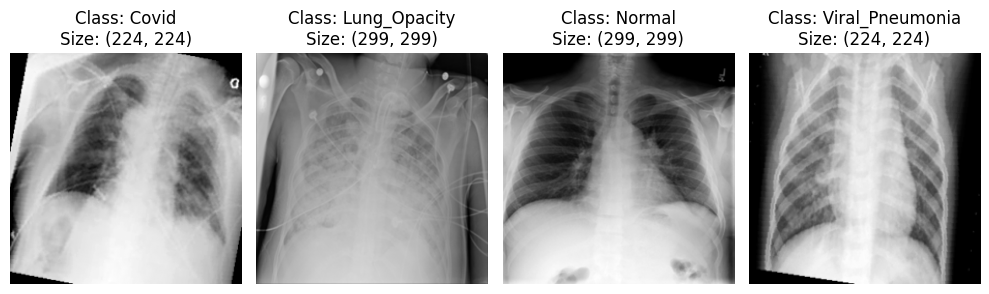

In [ ]:
random.seed(42)
NUM_IMAGES = 4
fig , ax = plt.subplots(1 , NUM_IMAGES , figsize = (10 , 5))

classes = ["Covid", "Lung_Opacity", "Normal", "Viral_Pneumonia"]
output_dir = "/content/drive/MyDrive/COVID19_split_ready"

images = []

# Sélectionner une image aléatoire par classe
for c in classes:
    imgs_total = list(Path(os.path.join(output_dir, "train", c)).glob("*.png"))
    if imgs_total:
        img_path = random.choice(imgs_total)
        images.append((img_path, c))     # Stocker chemin + nom de classe
    else:
        print(f"Aucune image trouvée pour la classe {c}")

# Affichage
for i, (img_path, class_name) in enumerate(images):
    img = Image.open(img_path).convert('L')
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Class: {class_name}\nSize: {img.size}")
    ax[i].axis("off")

fig.tight_layout()
plt.show()


----->>> **Les images sont de size differentes** : il faut faire une Transformation (Preprocessing)







# Point d'attention: !!!!!
dans ce projet , on a choisit de comparer 3 architectures de **COMPUTER VISION** bien connus , a savoir

**1. model CNN_MLP_Idee :** construit par nous (simple en construction ,innovation et idee personel)

**2. ResNet18 :** Architecture connus comme un Point de référence moderne et robuste

**3. EfficientNet-V2-S :** Modèle très performant et optimisé

**------------------------------------------------------------------------------------------------------------**

# Preprocessing :

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),             # Convertir en 3 canaux 'RGB' (fausses RGB car on fait juste dupliquer nos images)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                   # des valeurs entre 0 et 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],         # mean et std de ImageNet :
                         std=[0.229, 0.224, 0.225])
])


# Charger les datasets : ImageFolder assigne les labels selon le sous repertoire
data_dir = "/content/drive/MyDrive/COVID19_split_ready"



----------------------------------------------------------------------------

In [6]:
# Charger les datasets complets avec transform
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=transform)

from torch.utils.data import Subset

# une approche : pour reduire le nombre des images en entrainement et utilisé pour chercher le learning_rate optimal et
# avoir un idee sur l'Overfitting
random.seed(42)
# Sélection aléatoire de 2000 indices pour chaque dataset
train_indices = random.sample(range(len(train_dataset)), 2000)
val_indices   = random.sample(range(len(val_dataset)), 1000)

# Sous-ensembles aléatoires
train_subset = Subset(train_dataset, train_indices)
#val_subset   = Subset(val_dataset, val_indices)

# DataLoaders sur les subsets
train_loader_sub = DataLoader(train_subset, batch_size=32, shuffle=True)
#val_loader_sub   = Subset(val_dataset, val_indices)







# une approche utiliser principalement pour l'entrainement des 3 models:
random.seed(42)
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train") , transform=transform)
val_dataset   = datasets.ImageFolder(root=os.path.join(data_dir, "val")   , transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, "test")  , transform=transform)

# DataLoaders : lire la data en mini_batch = 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Les fonctions nécessaires pour entrainer les 3 architectures:

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc



def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, all_preds, all_labels




def test_model(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_true_labels = []
    misclassified_pred_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store misclassified images
            misclassified_mask = preds != labels
            misclassified_images.extend(inputs[misclassified_mask].cpu())
            misclassified_true_labels.extend(labels[misclassified_mask].cpu().numpy())
            misclassified_pred_labels.extend(preds[misclassified_mask].cpu().numpy())


    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Display misclassified images
    print("\nDisplaying a few misclassified images:")
    num_display = min(10, len(misclassified_images)) # Display up to 10 misclassified images
    if num_display > 0:
        fig, axes = plt.subplots(1, num_display, figsize=(20, 5))
        for i in range(num_display):
            img = misclassified_images[i].permute(1, 2, 0) # Change from (C, H, W) to (H, W, C)
            # Denormalize the image for display (assuming ImageNet normalization)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img.numpy() + mean
            img = np.clip(img, 0, 1) # Clip values to be between 0 and 1

            axes[i].imshow(img)
            axes[i].set_title(f"True: {classes[misclassified_true_labels[i]]}\nPred: {classes[misclassified_pred_labels[i]]}")
            axes[i].axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified images found.")

**-----------------------------------------------------**

**------------------------------------------------------**

# ***1) Model CNN_MLP_Idee:***


on construit un model en deux Blocs CNN_MLP :

Bloc1:   **2 convolutions**  de kernel_size=(5 ,5) et stride=1 , suivi d'une **ReLU** , et un **MAX_POOLING** de size = (4,4) avec padding=2 ,

suivi d'un Flatten() et Dense() , ReLU()
et une autre fois Flatten() et Dense()  .

Bloc2:  **2 convolutions**  de kernel_size=(3 ,3) et stride=1 , suivi d'une **ReLU** , et un **MAX_POOLING** de size = (2,2) avec padding=2 ,

suivi d'un Flatten() et Dense() , ReLU()
et une autre fois Flatten() et Dense() .

avec toujours des batch_normalization pour "**regularisation** , **stablilite numeriquee**  , **convergence** "

**----------------------------------------------------------------------**

on appelle le Bloc1 **CNN_details** (car ils captent les plus grandes details avec le kernel_size=(5,5) )

et le Bloc2 **CNN_lisse** avec kernel_size = (3,3)




In [25]:
import torch.nn.functional as F

class CNN_MLP(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_MLP, self).__init__()

        # Bloc 1 : CNN_details! Partie1(CNN)
        self.conv_layers1 = nn.Sequential(
            nn.Conv2d(in_channels=3 , out_channels=16 , kernel_size=5, stride=1, padding=0),            # conv1
            nn.BatchNorm2d(16) , nn.ReLU(),                                            #batch_norm()
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max Pooling avec padding=2

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),           # conv2
            nn.BatchNorm2d(32) , nn.ReLU(),                                             #batch_norm()
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max Pooling avec padding=2
        )



        # Pour calculer la taille des features à la sortie des convolutions,
        # il faut connaître la taille de l'image d'entrée , ici on a 224x224.
        dim_input = torch.zeros(1, 3, 224, 224)            #on a des images de 224*224 avec 3canaux RGB
        out = self.conv_layers1(dim_input)
        self.flattened_size1 = out.numel() // out.shape[0]  # nombre d'éléments par batch


        # Bloc 1 : CNN_details! Partie2(MLP))
        self.fc_layers1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size1, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),



        )

       # Reprojection vers (16 , 8, 8)
        self.reproject = nn.Linear(64, 16 * 8 * 8)               # = 256

        # Bloc 2 : CNN lisse! Partie1(CNN) - Added padding
        self.conv_layers2 = nn.Sequential(
            nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size=3, stride=1, padding=1),            # conv1
            nn.BatchNorm2d(32) , nn.ReLU(),                                            #batch_norm()
            nn.MaxPool2d(kernel_size=2, stride=2),                   # maxpool avec padding=2

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),           # conv2
            nn.BatchNorm2d(64) , nn.ReLU(),                                             #batch_norm()
            nn.MaxPool2d(kernel_size=2, stride=2),                   # maxpool avec padding=4
        )



        # Pour calculer la taille des features à la sortie des convolutions,
        # il faut connaître la taille de l'image d'entrée , ici on a 224x224.
        # Recalculate flattened_size2 based on new dimensions
        dim_input = self.reproject(torch.zeros(1, 64)).view(-1, 16, 8, 8)
        out = self.conv_layers2(dim_input)
        self.flattened_size2 = out.numel() // out.shape[0]  # number of elements per batch


        # Bloc 2 : CNN lisse: Partie2(MLP))
        self.fc_layers2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 16),
            nn.ReLU(),

            nn.Linear(16, num_classes),

        )



    def forward(self, x):
        x = self.conv_layers1(x)
        x = self.fc_layers1(x)
        x = self.reproject(x)          # -> (N, 256)
        x = x.view(-1, 16, 8, 8)
        x = self.conv_layers2(x)
        x = self.fc_layers2(x)
        return x

In [26]:
model = CNN_MLP(num_classes=4)
x = torch.randn(2, 3, 224, 224)  # batch de 2 images RGB
output = model(x)
print(output.shape)  # → torch.Size([2, 4])


torch.Size([2, 4])


In [27]:
!pip install torch-lr-finder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.77E-03


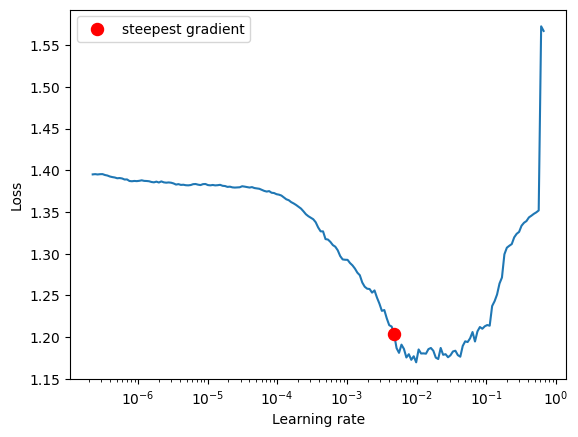

In [28]:
# cherchons le bon learning_rate pour CNN_MLP:

from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim

model = CNN_MLP(num_classes=4).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)  # point de départ

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_sub, end_lr=1, num_iter=200)
lr_finder.plot()              # affiche la courbe
lr_finder.reset()


In [29]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 4.77E-04 )        #learning_rate optimal = (lr trouvé)/10 pour plus  stabilite


Epoch 1/30


100%|██████████| 219/219 [01:23<00:00,  2.61it/s]


Train Loss: 0.9945 | Train Acc: 0.5356


100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Val Loss: 0.7420 | Val Acc: 0.6640
Modèle sauvegardé !
Epoch 2/30


100%|██████████| 219/219 [01:22<00:00,  2.65it/s]


Train Loss: 0.7462 | Train Acc: 0.6666


100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Val Loss: 0.6152 | Val Acc: 0.7613
Modèle sauvegardé !
Epoch 3/30


100%|██████████| 219/219 [01:23<00:00,  2.61it/s]


Train Loss: 0.6081 | Train Acc: 0.7657


100%|██████████| 47/47 [00:16<00:00,  2.85it/s]


Val Loss: 0.4868 | Val Acc: 0.8197
Modèle sauvegardé !
Epoch 4/30


100%|██████████| 219/219 [01:22<00:00,  2.64it/s]


Train Loss: 0.4912 | Train Acc: 0.8178


100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Val Loss: 0.4827 | Val Acc: 0.8343
Modèle sauvegardé !
Epoch 5/30


100%|██████████| 219/219 [01:23<00:00,  2.62it/s]


Train Loss: 0.4215 | Train Acc: 0.8487


100%|██████████| 47/47 [00:16<00:00,  2.80it/s]


Val Loss: 0.4648 | Val Acc: 0.8473
Modèle sauvegardé !
Epoch 6/30


100%|██████████| 219/219 [01:23<00:00,  2.63it/s]


Train Loss: 0.3766 | Train Acc: 0.8672


100%|██████████| 47/47 [00:16<00:00,  2.82it/s]


Val Loss: 0.4142 | Val Acc: 0.8537
Modèle sauvegardé !
Epoch 7/30


100%|██████████| 219/219 [01:22<00:00,  2.64it/s]


Train Loss: 0.3390 | Train Acc: 0.8792


100%|██████████| 47/47 [00:16<00:00,  2.82it/s]


Val Loss: 0.3950 | Val Acc: 0.8600
Modèle sauvegardé !
Epoch 8/30


100%|██████████| 219/219 [01:23<00:00,  2.63it/s]


Train Loss: 0.3059 | Train Acc: 0.8878


100%|██████████| 47/47 [00:16<00:00,  2.78it/s]


Val Loss: 0.3493 | Val Acc: 0.8887
Modèle sauvegardé !
Epoch 9/30


100%|██████████| 219/219 [01:23<00:00,  2.61it/s]


Train Loss: 0.2773 | Train Acc: 0.8995


100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Val Loss: 0.3438 | Val Acc: 0.8887
Epoch 10/30


100%|██████████| 219/219 [01:22<00:00,  2.64it/s]


Train Loss: 0.2545 | Train Acc: 0.9109


100%|██████████| 47/47 [00:16<00:00,  2.80it/s]


Val Loss: 0.3506 | Val Acc: 0.8870
Epoch 11/30


100%|██████████| 219/219 [01:23<00:00,  2.63it/s]


Train Loss: 0.2253 | Train Acc: 0.9170


100%|██████████| 47/47 [00:16<00:00,  2.79it/s]


Val Loss: 0.3886 | Val Acc: 0.8913
Modèle sauvegardé !
Epoch 12/30


100%|██████████| 219/219 [01:23<00:00,  2.63it/s]


Train Loss: 0.2103 | Train Acc: 0.9253


100%|██████████| 47/47 [00:16<00:00,  2.77it/s]


Val Loss: 0.3394 | Val Acc: 0.9020
Modèle sauvegardé !
Epoch 13/30


100%|██████████| 219/219 [01:23<00:00,  2.62it/s]


Train Loss: 0.1846 | Train Acc: 0.9347


100%|██████████| 47/47 [00:16<00:00,  2.86it/s]


Val Loss: 0.3243 | Val Acc: 0.8973
Epoch 14/30


100%|██████████| 219/219 [01:23<00:00,  2.64it/s]


Train Loss: 0.1650 | Train Acc: 0.9419


100%|██████████| 47/47 [00:16<00:00,  2.86it/s]


Val Loss: 0.3802 | Val Acc: 0.8877
Epoch 15/30


100%|██████████| 219/219 [01:22<00:00,  2.66it/s]


Train Loss: 0.1549 | Train Acc: 0.9454


100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Val Loss: 0.4205 | Val Acc: 0.8743
Epoch 16/30


100%|██████████| 219/219 [01:22<00:00,  2.66it/s]


Train Loss: 0.1463 | Train Acc: 0.9504


100%|██████████| 47/47 [00:16<00:00,  2.85it/s]


Val Loss: 0.3753 | Val Acc: 0.8863
Epoch 17/30


100%|██████████| 219/219 [01:22<00:00,  2.66it/s]


Train Loss: 0.1330 | Train Acc: 0.9526


100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Val Loss: 0.3710 | Val Acc: 0.8947
Early stopping triggered at epoch 17
Entraînement terminé.


100%|██████████| 47/47 [00:16<00:00,  2.81it/s]


Test Accuracy: 0.8910
Classification Report:
                 precision    recall  f1-score   support

          Covid       0.92      0.91      0.91       750
   Lung_Opacity       0.86      0.80      0.83       750
         Normal       0.82      0.87      0.85       750
Viral_Pneumonia       0.97      0.98      0.97       750

       accuracy                           0.89      3000
      macro avg       0.89      0.89      0.89      3000
   weighted avg       0.89      0.89      0.89      3000

Confusion Matrix:
[[680  28  32  10]
 [ 35 603 107   5]
 [ 17  69 654  10]
 [ 10   0   4 736]]

Displaying a few misclassified images:


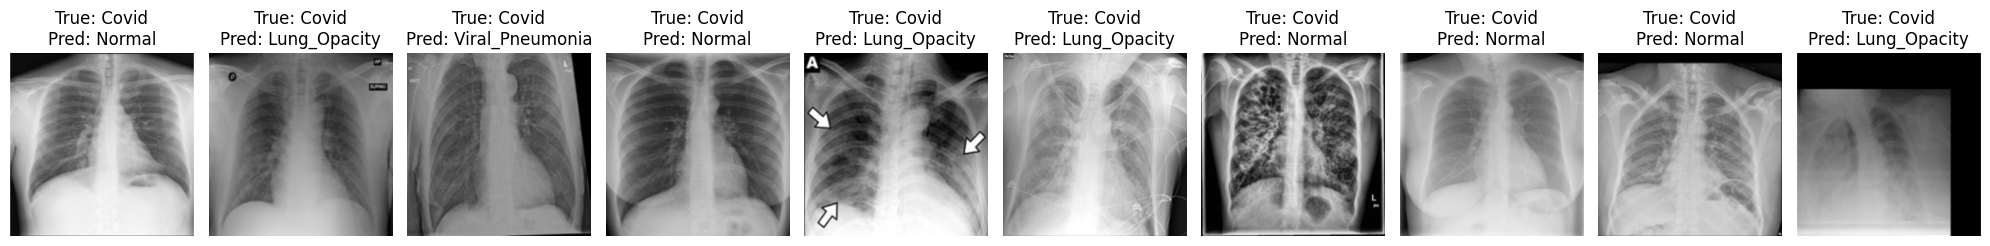

In [30]:
# --- Hyperparameters
num_epochs = 30
best_val_acc = 0.0
classes = ["Covid", "Lung_Opacity", "Normal", "Viral_Pneumonia"]

# Early stopping parameters
epochs_without_improvement = 0
patience = 5

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Move model to the appropriate device
model.to(device)

# Boucle d'entrainement :
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    val_loss, val_acc, _, _ = validate_one_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


    # Sauvegarde du meilleur modèle et Early Stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Modèle sauvegardé !")
        epochs_without_improvement = 0 # Reset counter on improvement
    else:
        epochs_without_improvement += 1 # Increment counter if no improvement

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break # Exit the training loop

print("Entraînement terminé.")

# Charger le meilleur modèle pour le test
model.load_state_dict(torch.load("best_model.pth"))

# Tester sur test set
test_model(model, test_loader, device, classes)

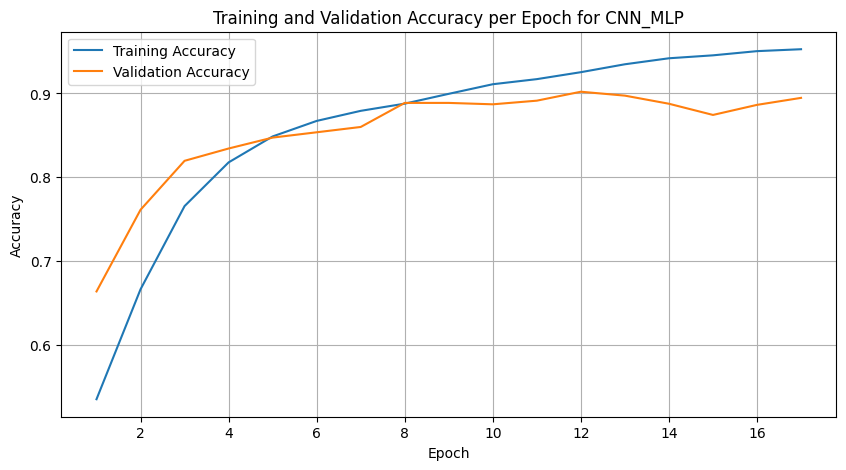

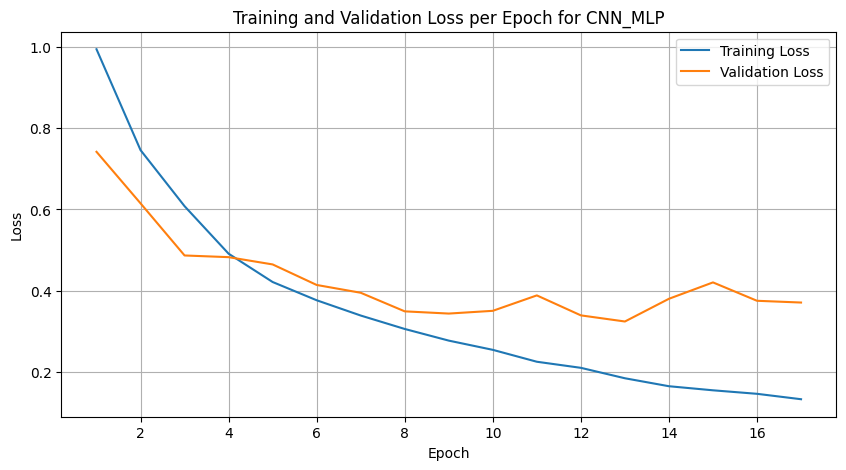

In [31]:
import matplotlib.pyplot as plt

# Plotting the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch for CNN_MLP')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch for CNN_MLP')
plt.legend()
plt.grid(True)
plt.show()

# **Analyse des Résultats** :

1) ***Petite variation  statistique*** : avec 14000 images en train et 3000 en test et validation , 7% comme un Gap= difference des erreurs (test et train) est normal (pas trop d'Overfitting )

2) ***Le loss se comporte de façon convenable avec l'accuracy*** , donc c'est un signe positif(l'entrainement est stable et coherent)

3) ***Le model generalise bien*** en prenant en compte la complexité du modele


**--------------------------------------------------------**

**--------------------------------------------------------**

#**2) Architecture ResNet18:**

on a choisi ***l'architecture*** **ResNet18** car c'est  un bon compromis :

Suffisamment **profond** pour apprendre des représentations puissantes

Mais pas trop lourd : on peux l’utiliser sans problème sur une machine avec GPU "moyen" comme dans notre cas 4GPU

ResNet18 -> 18 couches (très rapide, peu de paramètres)


In [8]:
!pip install torchvision

In [9]:
!pip install torchinfo

In [13]:
# Load the pre-trained ResNet18 model
# Use weights='DEFAULT' to load the best available weights
import torchvision.models as models


# Charger ResNet18 pré-entraîné sur ImageNet
resnet18 = models.resnet18(pretrained=True)


# Modify the last fully connected layer (fc)
# The classifier in ResNet18 is a Sequential module, and the last layer is fully connect layer
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 4)             # 4 classes

# Print the model summary:
from torchinfo import summary
summary(resnet18, input_size=(32, 3, 224, 224))              # batch size 32 and image size 224x224

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-04


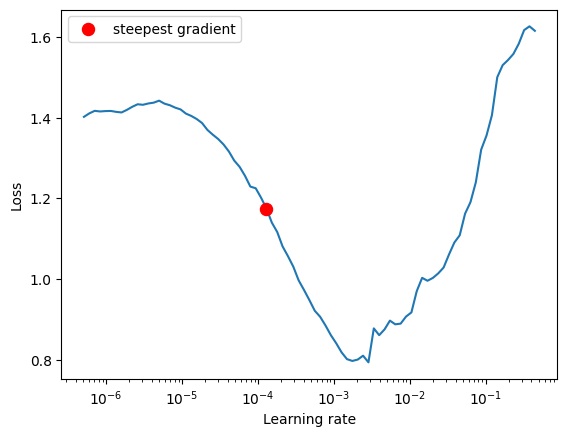

In [ ]:
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

model = models.resnet18(weights='DEFAULT')

# Modify the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)                   # Set the number of output classes here

# Move model to the appropriate device
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)         # point de départ

lr_finder = LRFinder(model, optimizer, criterion, device=device) # Use device variable
lr_finder.range_test(train_loader_sub, end_lr=1, num_iter=100)
lr_finder.plot()          # affiche la courbe
lr_finder.reset()

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr= 1.29E-04)


In [21]:
# --- Hyperparameters
num_epochs = 20
best_val_acc = 0.0
classes = ["Covid", "Lung_Opacity", "Normal", "Viral_Pneumonia"]

# Early stopping parameters
epochs_without_improvement = 0
patience = 4

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Move model to the appropriate device(cuda ou CPU)
model=resnet18.to(device)

# Boucle d'entrainement :
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    val_loss, val_acc, _, _ = validate_one_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


    # Sauvegarde du meilleur modèle et Early Stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Modèle sauvegardé !")
        epochs_without_improvement = 0           # Reset counter on improvement
    else:
        epochs_without_improvement += 1           # Increment counter if no improvement

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break                                    # Exit the training loop

print("Entraînement terminé.")

Epoch 1/20


100%|██████████| 219/219 [01:23<00:00,  2.63it/s]


Train Loss: 0.0191 | Train Acc: 0.9936


100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Val Loss: 0.1364 | Val Acc: 0.9650
Modèle sauvegardé !
Epoch 2/20


100%|██████████| 219/219 [01:23<00:00,  2.61it/s]


Train Loss: 0.0309 | Train Acc: 0.9888


100%|██████████| 47/47 [00:16<00:00,  2.82it/s]


Val Loss: 0.1565 | Val Acc: 0.9513
Epoch 3/20


100%|██████████| 219/219 [01:23<00:00,  2.62it/s]


Train Loss: 0.0203 | Train Acc: 0.9939


100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Val Loss: 0.1463 | Val Acc: 0.9617
Epoch 4/20


100%|██████████| 219/219 [01:23<00:00,  2.61it/s]


Train Loss: 0.0122 | Train Acc: 0.9970


100%|██████████| 47/47 [00:16<00:00,  2.81it/s]


Val Loss: 0.1390 | Val Acc: 0.9667
Modèle sauvegardé !
Epoch 5/20


100%|██████████| 219/219 [01:23<00:00,  2.63it/s]


Train Loss: 0.0061 | Train Acc: 0.9984


100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Val Loss: 0.1482 | Val Acc: 0.9707
Modèle sauvegardé !
Epoch 6/20


100%|██████████| 219/219 [01:23<00:00,  2.62it/s]


Train Loss: 0.0127 | Train Acc: 0.9954


100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Val Loss: 0.2100 | Val Acc: 0.9473
Epoch 7/20


100%|██████████| 219/219 [01:23<00:00,  2.62it/s]


Train Loss: 0.0089 | Train Acc: 0.9968


100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Val Loss: 0.1646 | Val Acc: 0.9617
Epoch 8/20


100%|██████████| 219/219 [01:23<00:00,  2.61it/s]


Train Loss: 0.0066 | Train Acc: 0.9979


100%|██████████| 47/47 [00:16<00:00,  2.82it/s]


Val Loss: 0.1690 | Val Acc: 0.9620
Epoch 9/20


100%|██████████| 219/219 [01:23<00:00,  2.62it/s]


Train Loss: 0.0073 | Train Acc: 0.9976


100%|██████████| 47/47 [00:16<00:00,  2.78it/s]

Val Loss: 0.1939 | Val Acc: 0.9573
Early stopping triggered at epoch 9
Entraînement terminé.


100%|██████████| 47/47 [00:16<00:00,  2.80it/s]


Test Accuracy: 0.9660
Classification Report:
                 precision    recall  f1-score   support

          Covid       0.98      0.99      0.98       750
   Lung_Opacity       0.96      0.93      0.94       750
         Normal       0.93      0.95      0.94       750
Viral_Pneumonia       0.99      1.00      0.99       750

       accuracy                           0.97      3000
      macro avg       0.97      0.97      0.97      3000
   weighted avg       0.97      0.97      0.97      3000

Confusion Matrix:
[[745   1   4   0]
 [  8 696  46   0]
 [  8  27 709   6]
 [  2   0   0 748]]

Displaying a few misclassified images:


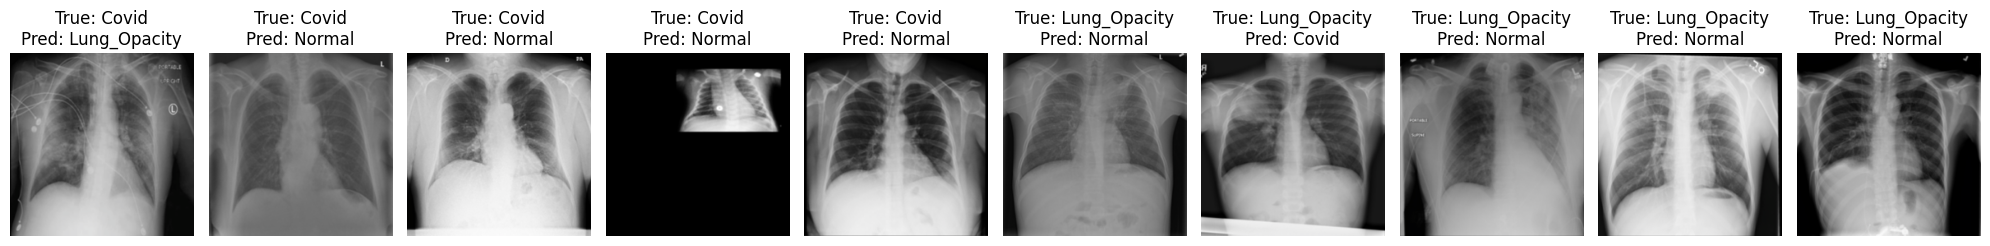

In [22]:

# Charger le meilleur modèle pour le test
model.load_state_dict(torch.load("best_model.pth"))

# Tester sur test set
test_model(model, test_loader, device, classes)

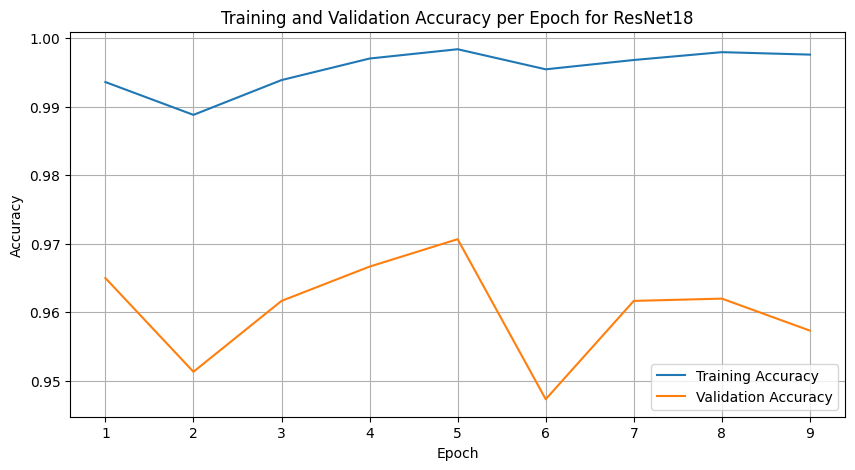

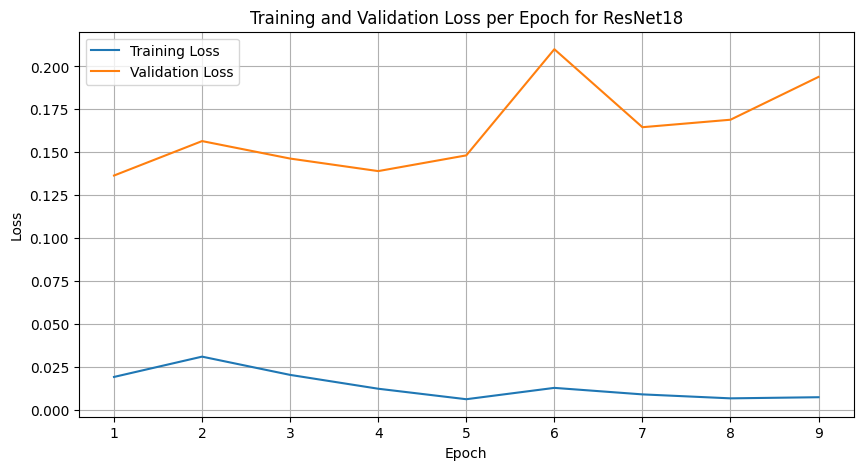

In [23]:
import matplotlib.pyplot as plt

# Plotting the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch for ResNet18')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch for ResNet18')
plt.legend()
plt.grid(True)
plt.show()

# **Analyse des Résulatas:**

1) ***Gap trés faible*** (~ 2points ) : bonne géneralisation

2) ***test_acc = 0.966*** coherent avec la val_acc

3) ***c'est normal :*** car ResNet18 est pré-entrainé sur ImageNet (14 million images ) ---> convergence plus rapide (9 epoch ) et plus stable

**----------------------------------------------------------**

**----------------------------------------------------------**

#**3)Architecture Efficientnetv2_s :**

In [24]:
from torchvision.models import efficientnet_v2_s
import torch.nn as nn

# EfficientNetV2-S
model_eff = efficientnet_v2_s(weights='DEFAULT')
num_ftrs_eff = model_eff.classifier[-1].in_features
model_eff.classifier[-1] = nn.Linear(num_ftrs_eff, 4)



Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 116MB/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.87E-04


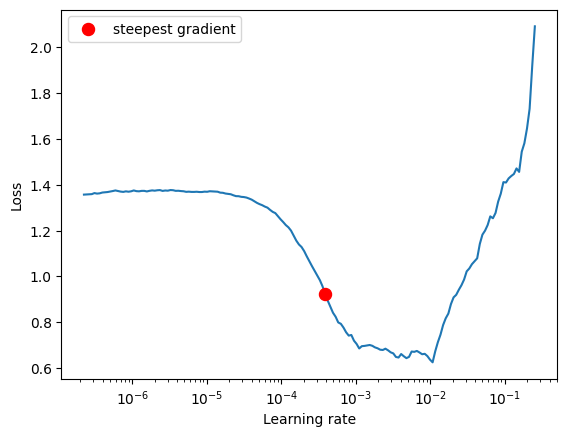

In [32]:
#Learning_rate optimal
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


model = models.efficientnet_v2_s(weights='DEFAULT')

# Modify the last fully connected layer in the classifier
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 4)


model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)       # point de départ

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_sub , end_lr=1, num_iter=200)
lr_finder.plot()        # affiche la courbe
lr_finder.reset()

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.87E-04)


In [34]:
# --- Hyperparameters
num_epochs = 20
best_val_acc = 0.0
classes = ["Covid", "Lung_Opacity", "Normal", "Viral_Pneumonia"]

# Early stopping parameters
epochs_without_improvement = 0
patience = 4

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Move model to the appropriate device(cuda ou CPU)
model=model.to(device)

# Boucle d'entrainement :
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    val_loss, val_acc, _, _ = validate_one_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


    # Sauvegarde du meilleur modèle et Early Stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Modèle sauvegardé !")
        epochs_without_improvement = 0           # Reset counter on improvement
    else:
        epochs_without_improvement += 1           # Increment counter if no improvement

    # Check for early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break                                    # Exit the training loop

print("Entraînement terminé.")

Epoch 1/20


100%|██████████| 219/219 [01:43<00:00,  2.11it/s]


Train Loss: 0.2386 | Train Acc: 0.9165


100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


Val Loss: 0.2205 | Val Acc: 0.9227
Modèle sauvegardé !
Epoch 2/20


100%|██████████| 219/219 [01:43<00:00,  2.12it/s]


Train Loss: 0.1135 | Train Acc: 0.9609


100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


Val Loss: 0.2265 | Val Acc: 0.9090
Epoch 3/20


100%|██████████| 219/219 [01:43<00:00,  2.12it/s]


Train Loss: 0.0753 | Train Acc: 0.9728


100%|██████████| 47/47 [00:17<00:00,  2.64it/s]


Val Loss: 0.0913 | Val Acc: 0.9667
Modèle sauvegardé !
Epoch 4/20


100%|██████████| 219/219 [01:43<00:00,  2.11it/s]


Train Loss: 0.0550 | Train Acc: 0.9806


100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


Val Loss: 0.1084 | Val Acc: 0.9647
Epoch 5/20


100%|██████████| 219/219 [01:43<00:00,  2.12it/s]


Train Loss: 0.0349 | Train Acc: 0.9878


100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


Val Loss: 0.1161 | Val Acc: 0.9593
Epoch 6/20


100%|██████████| 219/219 [01:43<00:00,  2.11it/s]


Train Loss: 0.0313 | Train Acc: 0.9894


100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


Val Loss: 0.1143 | Val Acc: 0.9653
Epoch 7/20


100%|██████████| 219/219 [01:43<00:00,  2.13it/s]


Train Loss: 0.0216 | Train Acc: 0.9923


100%|██████████| 47/47 [00:17<00:00,  2.62it/s]

Val Loss: 0.1280 | Val Acc: 0.9663
Early stopping triggered at epoch 7
Entraînement terminé.


100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


Test Accuracy: 0.9633
Classification Report:
                 precision    recall  f1-score   support

          Covid       0.98      0.99      0.98       750
   Lung_Opacity       0.97      0.91      0.94       750
         Normal       0.91      0.96      0.94       750
Viral_Pneumonia       1.00      0.99      0.99       750

       accuracy                           0.96      3000
      macro avg       0.96      0.96      0.96      3000
   weighted avg       0.96      0.96      0.96      3000

Confusion Matrix:
[[741   1   5   3]
 [  8 685  57   0]
 [  5  23 722   0]
 [  1   0   7 742]]

Displaying a few misclassified images:


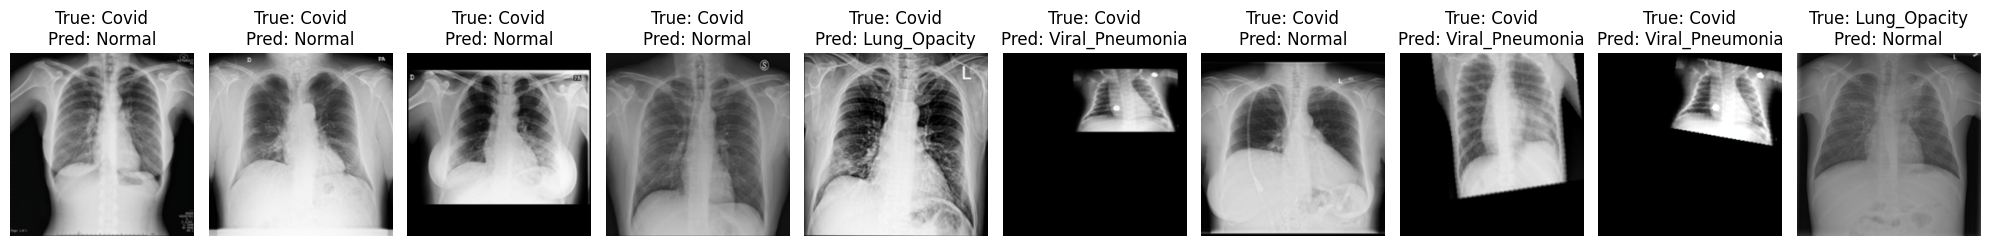

In [35]:
# Charger le meilleur modèle pour le test
model.load_state_dict(torch.load("best_model.pth"))

# Tester sur test set
test_model(model, test_loader, device, classes)


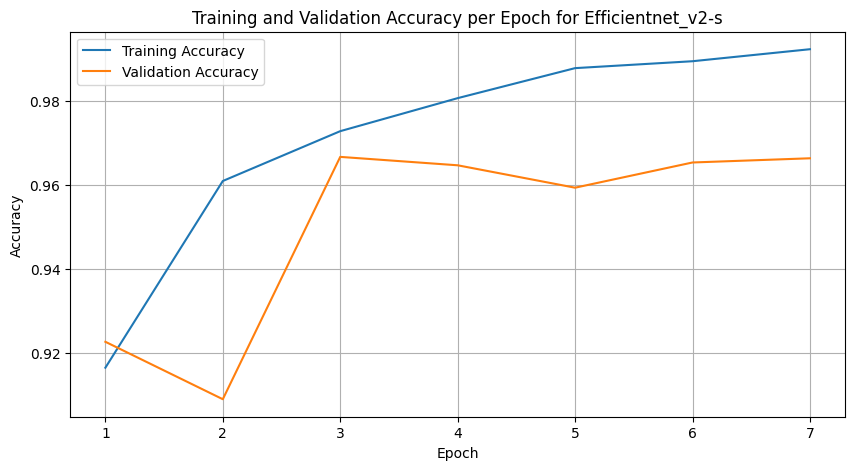

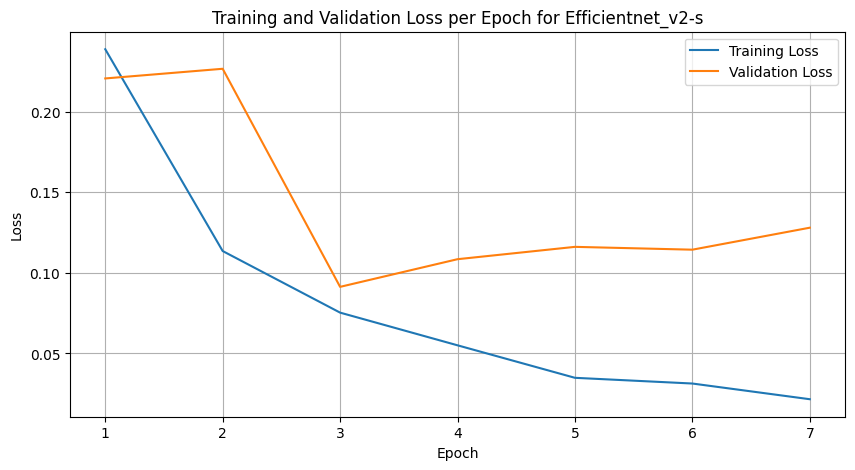

In [36]:
import matplotlib.pyplot as plt

# Plotting the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch for Efficientnet_v2-s')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch for Efficientnet_v2-s')
plt.legend()
plt.grid(True)
plt.show()

# **Analyse des Résulatas:**

1) ***Gap trés faible*** (~ moins d'un point ) : bonne géneralisation

2) ***test_acc = 0.9633*** coherent avec la val_acc

3) ***c'est normal :*** car EfficientNetV2-S  est pré-entrainé sur ImageNet (14 million images ) comme ResNet18 ---> convergence plus rapide (7 epoch ) et plus stable

4)***train_acc conyinue de monter toujours :*** le model a une trés forte capacité d'apprentissage ; mais plus de risque d'overitting si on fait pas early_stop

--> model tres **rapide** et **efficace**

# **Comparaison final:**

Ce projet compare un modèle from scratch **CNN_MLP** avec des architectures pré-entraînées.

Le modèle créé atteint ***0.89 de test***, tandis que ResNet18 et EfficientNetV2-S  atteignent ***0.96 ***,
montrant une meilleure généralisation grâce au transfert Learning .

 Cela illustre que, bien que le pré-entraînement offre de meilleures performances, la création d’un modèle **from scratch** reste essentielle pour comprendre et maîtriser les mécanismes d’apprentissage.

**---------------------------**

**---------------------------**

**---------------------------**


**Created by Ahmed Bennasser**
